# Simple neural network <a name="top"></a>

## Table of contents
1\. [Introduction](#introduction)  
2\. [Defining the data and the network topology](#2.)  
3\. [Training the network using numerical methods](#3.)  
4\. [Training the network using automatic differentiation](#4.)  
&nbsp;&nbsp;&nbsp;4.1 [Understanding PyTorch automatic differentiation (autograd)](#4.1)  
&nbsp;&nbsp;&nbsp;4.2 [Training the network using PyTorch's gradient computation](#4.2)  
&nbsp;&nbsp;&nbsp;4.3 [Training the network using PyTorch layers and functionals](#4.3)  
&nbsp;&nbsp;&nbsp;4.4 [Training the network using a PyTorch optimizer](#4.4)  
5\. [Using a PyTorch convolutional layer as a filter](#5.)  



# 1. Introduction <a name="introduction"></a>

Suppose we have a function of the form

$
y = f(x) = ax+b+n
$

where $a$ and $b$ are constants and $n$ represents some random noise. We will train a neural network to discover a function $f(x)$ that maps the $x$ data to the $y$ data. 

Note that the best approach to this problem would be to consider a linear regression using the following error function:

$
L=\sum_{i=1}^{N}(y_d(i)-y_e(i))^2
$

where $y_d(i)$ is the $y$ value obtained for object $i$ and $y_e(i)$ is given by

$
y_e(i) = ax_d(i)+b
$

where $x_d(i)$ is the $x$ value measured for object $i$.

We know that the values of $a$ and $b$ that minimize $L$ are given by the pseudo-inverse matrix:

$
\vec{r} = YX^T(XX^T)^{-1}
$

where $\vec{r}$ is a vector containg the best values for coeficients $a$ and $b$. 

Another, suboptimal, approach would be to apply gradient descent to optimize parameters $a$ and $b$. That is, calculate the gradient of $L$ with respect to $a$ and $b$ and then update the parameters as

$
a_{t+1}=a_t-e\frac{\partial{L}}{\partial{a_t}}
$

$
b_{t+1}=b_t-e\frac{\partial{L}}{\partial{b_t}}
$

where $e$ is a constant adjusting the amount of change applied to the variables (learning rate). 

But in the following we will try to train a neural network to represent the function $f(x)$. Note that the neural network has no prior knowledge of the model we want to fit. It only has the input and output data. Thus, although our example involves doing a simple linear regression, the same approach could be used to adjust to a dataset any function of the form $y=f(x)$.

[Back to top](#top)
# 2. Defining the data and the network topology <a name="2."></a> 

### Fake data

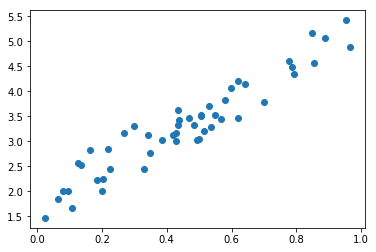

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

np.random.seed(2)

# Generate our fake data having 50 points
N = 50

x_data = np.random.rand(N)
y_data = 3.4*x_data+1.3+np.random.rand(N)

plt.figure()
plt.plot(x_data, y_data, 'o')

### Network

In [23]:
input_size = 1             # number of nodes in the first (input) layer
size_hidden_layer1 = 10    # number of nodes in the first hidden layer
size_hidden_layer2 = 10    # number of nodes in the second hidden layer
output_size = 1            # number of nodes in the last (output) layer

def apply_model(model, input):   
    '''Apply model to input data. Variable 'model' is a list of layers and
    varialbe 'input' is a scalar'''
    
    activation = input
    for mat in model[:-1]:
        activation = np.dot(mat, activation)    # Compute linear combination
        activation = 1/(1+np.exp(-activation))       # Apply logistic function
    activation = np.dot(model[-1], activation)
    # Since we have a regression problem, we do not apply the logistic function
    # to the output
    
    return activation

# Example of model application:

# Randomly initialize the weights
M1 = np.random.rand(size_hidden_layer1, 1)
M2 = np.random.rand(size_hidden_layer2, size_hidden_layer1)
M3 = np.random.rand(1, size_hidden_layer2)

model = [M1, M2, M3]
output = apply_model(model, 0.5)

Our model is the following:

<img src=https://i.imgur.com/mdPfEtx.png width="200">

[Back to top](#top)
# 3. Training the network using numerical methods <a name="3."></a>

Our first approach will be to train the network using numerical methods. Basically, this amounts to applying out model to a data point and calculating the error $L$. Then, we slightly change one of the weights, let's call it $w$, of the network by an amount $\Delta w$ and recalculate the error, call it $\tilde{L}$. The derivative of $L$ with respect to weight $w$ can then be calculated as

$
\large
\frac{\partial{L}}{\partial{w}} \approx \frac{L(w+\Delta w) - L(w)}{\Delta w} = \frac{\tilde{L}-L}{\Delta w}
$

By repeating the procedure for all weights of the network, we can obtain an estimation of the gradient of $L$.

Then, for each weight, we update it by doing

$
\large
w^i_{t+1} = w^i_t - e\frac{\partial{L}}{\partial{w^i_t}}
$

where $e$ is the learning rate.

In [24]:
def find_gradient(model, input, expected_output):
    '''Find gradient of the regression error with respect to the weights
    of the model. Variable 'expected_output' contains the expected y value
    given the input. '''
    
    step = 0.01  # \Delta w
    
    output = apply_model(model, input)
    error = (output-expected_output)**2
    
    gradient = []
    for layer_index, mat in enumerate(model):
        gradient.append(np.zeros(mat.shape))
        for row in range(mat.shape[0]):
            for col in range(mat.shape[1]):
                mat[row, col] += step
                output = apply_model(model, input)
                mat[row, col] -= step
                
                error_pert = (output-expected_output)**2
                gradient[layer_index][row, col] = (error_pert-error)/step
                
    return gradient

def update_parameters(model, gradient, learning_rate):
    '''Update the weights of the neural network'''
    
    for layer_index, mat in enumerate(model):
        mat -= learning_rate*gradient[layer_index]
    
def plot_data(x_data, y_data, x_model, y_model, epoch, ax):
    '''Auxiliary function for plotting the data'''
    
    ax.clear()
    ax.plot(x_data, y_data, 'o')
    ax.plot(x_model, y_model, 'o')
    ax.set_title('Epoch %d'%epoch, size=18)
    display.display(ax.figure)
    display.clear_output(wait=True) 

CPU times: user 49.3 s, sys: 3.64 s, total: 52.9 s
Wall time: 48 s


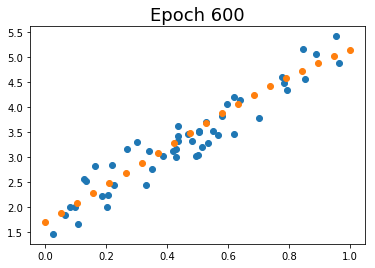

In [25]:
%%time

learning_rate = 0.01
num_epochs = 600      # Number of times we iterate over the entire data

# Randomly initialize model
M1 = np.random.rand(size_hidden_layer1, 1)
M2 = np.random.rand(size_hidden_layer2, size_hidden_layer1)
M3 = np.random.rand(1, size_hidden_layer2)

model = [M1, M2, M3]

x_new_data = np.linspace(0, 1, 20)  # x values used for ploting the shape of the function

fig = plt.figure()
ax = fig.add_subplot(111)
for epoch in range(num_epochs+1):
    # For each datapoint
    for i in range(x_data.size):
        gradient = find_gradient(model, x_data[i], y_data[i])
        update_parameters(model, gradient, learning_rate)
    
    # Plot data
    if epoch%5==0:
        y_est = np.zeros(x_new_data.size)
        # Apply current model to some x values
        for i in range(x_new_data.size):
            y_est[i] = apply_model(model, x_new_data[i])
        plot_data(x_data, y_data, x_new_data, y_est, epoch, ax)

We now have a neural network model representing our function $f(x)$!

If we want to use this model, we just need to apply it to some x values:

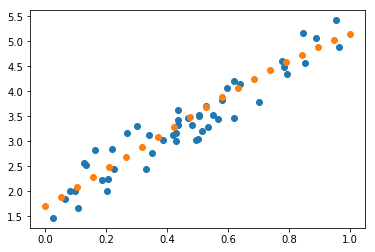

In [5]:
x_new_data = np.linspace(0, 1, 20) 
y_est = np.zeros(x_new_data.size)
for i in range(x_new_data.size):
    y_est[i] = apply_model(model, x_new_data[i])
    
plt.figure()
plt.plot(x_data, y_data, 'o')
plt.plot(x_new_data, y_est, 'o')

[Back to top](#top)
# 4. Training the network using automatic differentiation <a name="4."></a>

Automatic differentiation is a technique for computing and propagating derivatives using the chain rule, which is the main operation of any neural network using the backpropagation algorithm and gradient descent. PyTorch is a library for doing automatic differentiation.

## 4.1 Understanding PyTorch automatic differentiation (autograd) <a name="4.1"></a>

In [6]:
import torch

# Create a tensor having value 1. requires_grad=True means that
# we want to compute the gradient with respect to this variable
x = torch.tensor(1., requires_grad=True)
y = 4*x**2

# Computes the gradient of y with respect to all variables that
# y depends on. In this case, it will compute the gradient of 
# y with respect to x
y.backward()

# The component of the gradient dydx gets stored in the attribute 
# grad of variable x
dydx = x.grad

# dydx = 8*x = 8
print(dydx)

tensor(8.)


### Let's do the same as above, but with a more complex expression

We will define the expression 

$
\large
y = x_1*x_2 + x_3^2 - \frac{x_4}{x_2}
$

and then calculate the gradient of y, which is given by

$
\large
\nabla y = (\frac{\partial{y}}{\partial{x1}}, \frac{\partial{y}}{\partial{x2}}, \frac{\partial{y}}{\partial{x3}}, \frac{\partial{y}}{\partial{x4}})
$

In [7]:
def function(x1, x2, x3, x4):
    
    y = x1*x2 + x3**2 - x4/x2
    return y

def gradient(y, x1, x2, x3, x4):
    
    y.backward()
    gradient = [x1.grad, x2.grad, x3.grad, x4.grad]
    return gradient

x1 = torch.tensor(2., requires_grad=True)
x2 = torch.tensor(3., requires_grad=True)
x3 = torch.tensor(1., requires_grad=True)
x4 = torch.tensor(4., requires_grad=True)

y = function(x1, x2, x3, x4)
grad = gradient(y, x1, x2, x3, x4)

dydx1, dydx2, dydx3, dydx4 = grad

# dydx1 = x2 = 3
print(dydx1)

# dydx2 = x1 + x4/x2**2 = 2 + 4/9 = 2.4444
print(dydx2)

# dydx3 = 2*x3 = 2
print(dydx3)

# dydx4 = -1/x2 = -0.33333
print(dydx4)

tensor(3.)
tensor(2.4444)
tensor(2.)
tensor(-0.3333)


### We can also compute the gradients of composed functions

$
\begin{align}
& y(x) = 3*x^2 \\
& z(y) = y^4 \\
\end{align}
$

$
\begin{align}
\frac{\partial{z}}{\partial{x}} & = \frac{\partial{z}}{\partial{y}}\frac{\partial{z}}{\partial{x}} \\
\frac{\partial{z}}{\partial{x}} & = 4*y^3 * 6*x
\end{align}
$

In [8]:
def y_func(x):
    return 3*x**2

def z_func(y):
    return y**4

x = torch.tensor(2., requires_grad=True)
y = y_func(x)
z = z_func(y)

# By default Pytorch only keeps the gradient of leaf variables (x variable in our case)
# If we want to print the value of an intermediate variable, we need to call retain_grad
# (or define a hook to print the value)
y.retain_grad() 
z.backward()

# dzdx = 4*y**3*6*x = (4*12**3)*6*2 = 82944
print(x.grad)

# dzdy = 4*y**3 = 4*12**3 = 6912
print(y.grad)

tensor(82944.)
tensor(6912.)


### We can compute the gradient of any complex expression

For instance, for regression, we usually want to compare the difference between the observed data ($y_d$) and the values estimated from a model ($y_e$). This is done by computing the summed square distance between the two quantities:

$
\large
L_2(\vec{y}_d, \vec{y}_e) = \sum_{i=1}^{N}(y_d(i)-y_e(i))^2
$

where $y_e(i)$ is calculated as

$
\large
y_e(i) = W\vec{x}_\mathrm{input}^i
$

$\vec{x}_\mathrm{input}^i$ is the feature vector of object $i$

In [9]:
# Generate an array of fake input data. Each column represents an object (e.g., an image) 
# and each row a feature. Therefore, we have 100 objects and 10 features
x_input = torch.rand(10, 100) # By default, requires_grad=False. We do not need this variable for gradient computation

# Generate an array of fake y observed values
y_d = torch.rand(100) 

W = torch.rand(1, 10, requires_grad=True)  # We want to compute gradients with respect to these variables
y_e = torch.mm(W, x_input) # Can be replaced by W@x_input

L2 = torch.sum((y_d - y_e)**2)

L2.backward()

# Print gradient of L2 with respect to the weights in W
print(W.grad)

tensor([[78.5213, 83.7723, 77.8165, 85.9604, 91.7988, 85.2954, 84.9152, 99.0509,
         85.1906, 81.4691]])


[Back to top](#top)
# 4.2 Training the network using PyTorch's gradient computation <a name="4.2"></a>

### Converting the data from numpy to tensors

In [10]:
# By default, the numpy arrays are of type double (64 bits). It is common
# to use 32 bits in neural networks
x_data_t = torch.from_numpy(x_data).float()
y_data_t = torch.from_numpy(y_data).float()
# Note that torch.from_numpy() does not copy the data. Any change
# made to the tensor will reflect on the numpy array. But the conversion to float
# done using .float() does copy the data. Alternatively, we could have done
# torch.tensor(x_data, dtype=torch.float)
# which also copies the data

# Generate random weights using PyTorch functions
M1 = torch.rand(size_hidden_layer1, 1, requires_grad=True)
M2 = torch.rand(size_hidden_layer2, size_hidden_layer1, requires_grad=True)
M3 = torch.rand(1, size_hidden_layer2, requires_grad=True)

model = [M1, M2, M3]

### Redefining apply_model() and find_gradient() functions to use torch operations

In [11]:
def apply_model_torch(model, input):   
    activ = input.view(1,1)      # The input, which is a scalar, needs to be a 2D tensor with size 1x1
    for mat in model[:-1]:
        activ = torch.mm(mat, activ)   # Matrix multiplication, can be replaced by mat@activ
        activ = torch.sigmoid(activ)
    activ = torch.mm(model[-1], activ)
    
    return activ

def find_gradient_torch(model, input, expected_output):
    
    output = apply_model_torch(model, input)
    error = (output-expected_output)**2
    
    error.backward()
    
    gradient = []
    for mat in model:
        gradient.append(mat.grad.clone()) # 2D array containing gradient values
 
    # Each time .backward() is called, PyTorch accumulates the gradient. But we do not want that,
    # we want a new gradient for each epoch, therefore, we need to remember to erase the computed
    # gradients for the next .backward() call:
    for mat in model:
        mat.grad.zero_()   

    return gradient

def update_parameters_torch(model, gradient, learning_rate):
    # torch.no_grad() avoids keeping track of the gradient while we are updating the weights. 
    with torch.no_grad():
        for layer_index, mat in enumerate(model):
            mat -= learning_rate*gradient[layer_index]     

CPU times: user 1min 49s, sys: 0 ns, total: 1min 49s
Wall time: 13.7 s


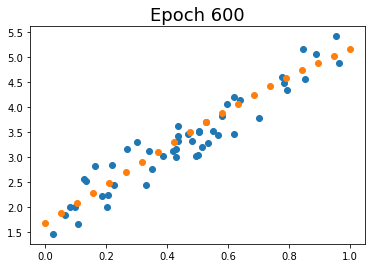

In [12]:
%%time

learning_rate = torch.tensor(0.01)
num_epochs = 600

x_new_data = torch.linspace(0, 1, 20)

fig = plt.figure()
ax = fig.add_subplot(111)
for epoch in range(num_epochs+1):
    # Here we calculate the gradient for each analyzed data point. We could also
    # calculate the loss for all data points and then calculate the gradient
    for i in range(x_data.size):
        
        gradient = find_gradient_torch(model, x_data_t[i], y_data_t[i])
        update_parameters_torch(model, gradient, learning_rate)

    if epoch%5==0:
        y_est = torch.zeros(len(x_new_data))
        with torch.no_grad():
            for i in range(len(x_new_data)):
                out = apply_model_torch(model, x_new_data[i])
                y_est[i] = out

        plot_data(x_data, y_data, x_new_data.numpy(), y_est.numpy(), epoch, ax)

If we want to train the network on the GPU, the code is pretty much the same.
We define a device:

```python
device = torch.device("cuda:0")
```
and make sure that our created tensors are put on the GPU, using commands like:

```python
x_data_t = torch.from_numpy(x_data).float().to(device)
M1 = torch.rand(size_hidden_layer1, 1, requires_grad=True, device=device)
```

Also, when converting back to numpy, we need to first put the array on the CPU:

```python
y_est[i] = out.cpu().numpy()
```

### Using batches

So far we have been applying our model and updating the gradient for every single data point. But we do not really need to do it that way. We can calculate the sum of the errors for a set of inputs and then update the gradient using all of these inputs together. The set of inputs is called a batch.

In [13]:
def find_gradient_batch_torch(model, input, expected_output):
    
    output = torch.zeros(len(input))
    for i,val in enumerate(input):
        output[i] = apply_model_torch(model, input[i])
    error = torch.sum((output-expected_output)**2)
    
    error.backward()
    
    gradient = []
    for mat in model:
        gradient.append(mat.grad.clone()) # 2D array containing gradient values
 
    # Each time .backward() is called, PyTorch accumulates the gradient. But we do not want that,
    # we want a new gradient for each epoch, therefore, we need to remember to erase the computed
    # gradients for the next .backward() call:
    for mat in model:
        mat.grad.zero_()   

    return gradient

CPU times: user 1min 38s, sys: 0 ns, total: 1min 38s
Wall time: 12.4 s


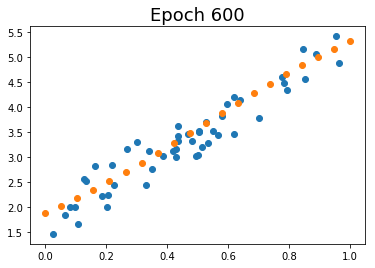

In [14]:
%%time

# We will use 5 inputs together to calculate the gradient and update the parameters
batch_size = 5
num_batches = int(len(x_data_t)/batch_size)

M1 = torch.rand(size_hidden_layer1, 1, requires_grad=True)
M2 = torch.rand(size_hidden_layer2, size_hidden_layer1, requires_grad=True)
M3 = torch.rand(1, size_hidden_layer2, requires_grad=True)

model = [M1, M2, M3]

fig = plt.figure()
ax = fig.add_subplot(111)
for epoch in range(num_epochs+1):
    for batch_index in range(num_batches):
        batch_data_index = slice(batch_size*batch_index, batch_size*(batch_index+1))     
        gradient = find_gradient_batch_torch(model, x_data_t[batch_data_index], y_data_t[batch_data_index])
        update_parameters_torch(model, gradient, learning_rate)

    if epoch%5==0:
        y_est = torch.zeros(len(x_new_data))
        with torch.no_grad():
            for i in range(len(x_new_data)):
                out = apply_model_torch(model, x_new_data[i])
                y_est[i] = out

        plot_data(x_data, y_data, x_new_data.numpy(), y_est.numpy(), epoch, ax)

[Back to top](#top)
# 4.3 Training the network using PyTorch layers and functionals <a name="4.3"></a>

Instead of defining the matrices ourselves, we will now use standard matrices provided by PyTorch. Specifically, the nn.Linear layer, with is pretty much just a matrix of random values. We will also replace the torch.sigmoid function by the Sigmoid class, which are pretty much the same, but the class can be used in nn.Sequential.

Also, we will replace error = torch.sum((output-expected_output)\**2) by a call to torch.nn.MSELoss()

In [15]:
def find_gradient_update_parameters(model, input, expected_output, learning_rate):
    '''This function will replace find_gradient_torch() and update_parameters_torch()'''
    
    # A column tensor is expected, thus we use .view(-1, 1)
    output = model(x_data_t[batch_data_index].view(-1,1))
    loss = loss_fn(output, y_data_t[batch_data_index].view(-1,1))

    # Zero the gradients for avoiding .backward() pass to accumulate values
    model.zero_grad()
    loss.backward()
    # Notice that now we acess parameters using model.parameters()
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

CPU times: user 1min 22s, sys: 0 ns, total: 1min 22s
Wall time: 10.4 s


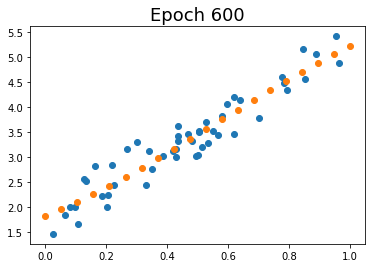

In [16]:
%%time

# Define the model. We use bias=False because our previous network did not have these. But
# they are usually included in a neural network.
model = torch.nn.Sequential(
    torch.nn.Linear(1, size_hidden_layer1, bias=False),
    torch.nn.Sigmoid(),
    torch.nn.Linear(size_hidden_layer1, size_hidden_layer2, bias=False),
    torch.nn.Sigmoid(),
    torch.nn.Linear(size_hidden_layer2, 1, bias=False)
)

# Error function, mean squared error. Note that the mean is not calculated if reduction='sum'
loss_fn = torch.nn.MSELoss(reduction='sum')

fig = plt.figure()
ax = fig.add_subplot(111)
for epoch in range(num_epochs+1):
    for batch_index in range(num_batches):
        batch_data_index = slice(batch_size*batch_index, batch_size*(batch_index+1))
        find_gradient_update_parameters(model, x_data_t[batch_data_index], 
                                        y_data_t[batch_data_index], learning_rate)

    if epoch%5==0:
        with torch.no_grad():
            output = model(x_new_data.view(-1,1))
            y_est = output.numpy()

        ax.clear()
        ax.plot(x_data, y_data, 'o')
        ax.plot(x_new_data.numpy(), y_est, 'o')
        ax.set_title('Epoch %d'%epoch, size=18)
        #ax.set_xlim((0,1))
        #ax.set_ylim((0,15))
        display.display(fig)
        display.clear_output(wait=True)   

[Back to top](#top)
# 4.4 Training the network using a PyTorch optimizer <a name="4.4"></a>

To wrap everything, we will now use a PyTorch optimizer, which will replace update_parameters_torch().

We will also avoid using the functions defined avobe in order to have a complete training loop without external dependencies.

CPU times: user 1min 23s, sys: 0 ns, total: 1min 23s
Wall time: 10.5 s


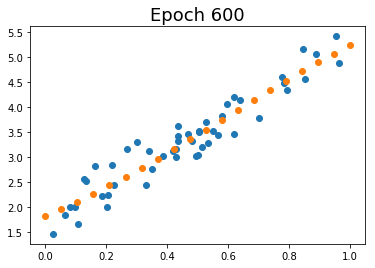

In [17]:
%%time

# Define the model
model = torch.nn.Sequential(
    torch.nn.Linear(1, size_hidden_layer1, bias=False),
    torch.nn.Sigmoid(),
    torch.nn.Linear(size_hidden_layer1, size_hidden_layer2, bias=False),
    torch.nn.Sigmoid(),
    torch.nn.Linear(size_hidden_layer2, 1, bias=False)
)

# Loss function
loss_fn = torch.nn.MSELoss(reduction='sum')

# Optimizer. We pass the parameters that will need update
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

fig = plt.figure()
ax = fig.add_subplot(111)
for epoch in range(num_epochs+1):
    for batch_index in range(num_batches):
        batch_data_index = slice(batch_size*batch_index, batch_size*(batch_index+1))
        # apply model to batch
        output = model(x_data_t[batch_data_index].view(-1,1))
        # Calculate loss
        loss = loss_fn(output, y_data_t[batch_data_index].view(-1,1))
    
        # Zero the gradients to avoid accumulating the values
        optimizer.zero_grad() 

        # Calculate the gradients
        loss.backward()
        # Update the weights
        optimizer.step()

    # Plot data
    if epoch%5==0:
        with torch.no_grad():
            output = model(x_new_data.view(-1,1))
            y_est = output.numpy()

        ax.clear()
        ax.plot(x_data, y_data, 'o')
        ax.plot(x_new_data.numpy(), y_est, 'o')
        ax.set_title('Epoch %d'%epoch, size=18)
        #ax.set_xlim((0,1))
        #ax.set_ylim((0,15))
        display.display(fig)
        display.clear_output(wait=True)   

### Training on the GPU

To train the model on the GPU, we just need to do 

device = torch.device("cuda")
model.to(device)  # or model.to('cuda')

and also put our inputs and outputs of a batch on the GPU before calling the model:

x_data_t[batch_data_index].view(-1,1).to(device)

y_data_t[batch_data_index].view(-1,1).to(device)

When converting the data to numpy, we also need to first put the tensor on the CPU again, calling

output.cpu().numpy()

CPU times: user 13.6 s, sys: 365 ms, total: 14 s
Wall time: 15.1 s


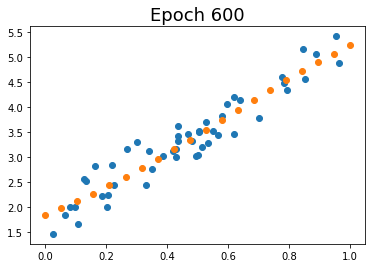

In [18]:
%%time

# Define the model
model = torch.nn.Sequential(
    torch.nn.Linear(1, size_hidden_layer1, bias=False),
    torch.nn.Sigmoid(),
    torch.nn.Linear(size_hidden_layer1, size_hidden_layer2, bias=False),
    torch.nn.Sigmoid(),
    torch.nn.Linear(size_hidden_layer2, 1, bias=False)
)

device = torch.device("cuda") #model.to(device) # or model.to('cuda')
model.to(device)

# Loss function
loss_fn = torch.nn.MSELoss(reduction='sum')

# Optimizer. We pass the parameters that will need update
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

fig = plt.figure()
ax = fig.add_subplot(111)
for epoch in range(num_epochs+1):
    for batch_index in range(num_batches):
        batch_data_index = slice(batch_size*batch_index, batch_size*(batch_index+1))
        # apply model to batch
        output = model(x_data_t[batch_data_index].view(-1,1).to(device))
        # Calculate loss
        loss = loss_fn(output, y_data_t[batch_data_index].view(-1,1).to(device))
    
        # Zero the gradients to avoid accumulating the values
        optimizer.zero_grad() 

        # Calculate the gradients
        loss.backward()
        # Update the weights
        optimizer.step()

    # Plot data
    if epoch%5==0:
        with torch.no_grad():
            output = model(x_new_data.view(-1,1).to(device))
            y_est = output.cpu().numpy()

        ax.clear()
        ax.plot(x_data, y_data, 'o')
        ax.plot(x_new_data.numpy(), y_est, 'o')
        ax.set_title('Epoch %d'%epoch, size=18)
        display.display(fig)
        display.clear_output(wait=True)   

[Back to top](#top)
# 5. Using a PyTorch convolutional layer as a filter <a name="5."></a>

A PyTorch convolutional layer is just a filter applied to an image. In order to better understand that, we will try to apply a Sobel filter to an image.

### Using nn.Conv2d

In [19]:
# Read image
import PIL

# The usual approach to read an image would be 
# img = plt.imread('cameraman.tiff')
# or using OpenCV. But in deep learning people commonly use the Pillow module
img = PIL.Image.open('cameraman.tiff')
img = np.array(img)

# To convert PIL image directly to a tensor:
#img_t = torchvision.transforms.ToTensor()(img)
# But this reescales the image to the [0,1] range. It also returns a tensor having size (1xHxW)

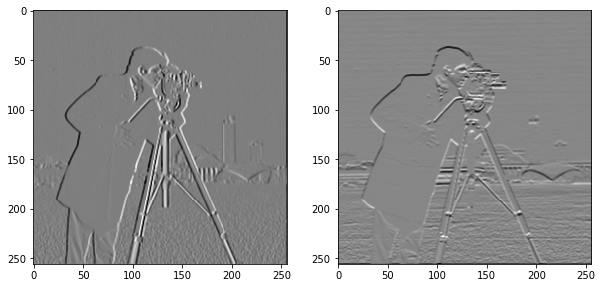

In [20]:
sobel_x = np.array([[-1, 0, 1],
                    [-2, 0, 2],
                    [-1, 0, 1]])
sobel_y = sobel_x.T

# Convert numpy arrays to tensors
img_t = torch.from_numpy(img).float()
sobel_x_t = torch.from_numpy(sobel_x).float()
sobel_y_t = torch.from_numpy(sobel_y).float()

# Create convolutional layer to be applied to an image having 1 channel. out_channels sets the number of 
# filters to use in this layer. We will use two filters.
conv = torch.nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1, padding=1, bias=False)

# Parameters of the convolutional layer, randomly initialized by PyTorch. 
# Has size (out_channels x in_channels x H x W) = 2x1x3x3
parameters = conv.weight.data
# Change the parameters to Sobel filters
parameters[0,0] = sobel_x_t
parameters[1,0] = sobel_y_t

with torch.no_grad():
    # Input image must have size (batch_size x in_channels x H x W) = 1x1xHxW
    img_out_t = conv(img_t.view(1, 1, img_t.shape[0], img_t.shape[1]))
# Output image has size batch_size x out_channels x H x W = 1x2xHxW
img_out = img_out_t.squeeze().numpy()

plt.figure(figsize=[10,10])
plt.subplot(1, 2, 1)
plt.imshow(img_out[0], 'gray')
plt.subplot(1, 2, 2)
plt.imshow(img_out[1], 'gray')

### Using nn.functional.conv2d

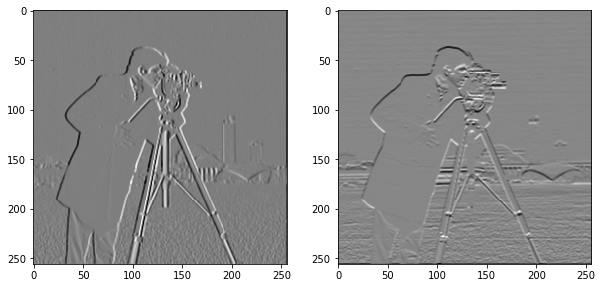

In [21]:
# The correct approach to just apply a convolution to an image is to use PyTorch functionals

sobel_t = torch.stack([sobel_x_t, sobel_y_t], dim=0).view(2,1,3,3)
out_img = torch.nn.functional.conv2d(img_t.view(1, 1, img_t.shape[0], img_t.shape[1]), 
                                     sobel_t, 
                                     stride=1, padding=1) 

img_out2 = img_out_t.squeeze().numpy()

plt.figure(figsize=[10,10])
plt.subplot(1, 2, 1)
plt.imshow(img_out[0], 'gray')
plt.subplot(1, 2, 2)
plt.imshow(img_out[1], 'gray')

[Back to top](#top)